# Libraries and Helper Functions

In [9]:
import pandas as pd
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import seaborn as sn
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler
import warnings
warnings.simplefilter('ignore')
%matplotlib inline
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation

In [83]:
def model_evaluation(X, y, model, label):
    predictions = model.predict(X)
    #calculate accuracy
    accuracy = accuracy_score(y, predictions)
    print('{0} Accuracy: {1:.4f}'.format(label, accuracy))
    #calculate precision
    precision_weighted = precision_score(y, predictions, labels=sorted(y.unique()), average='weighted')
    print('{0} Precision - Weighted: {1:.4f}'.format(label, precision_weighted))
    #calculate recall
    recall_weighted = recall_score(y, predictions, labels=sorted(y.unique()), average='weighted')
    print('{0} Recall - Weighted: {1:.4f}'.format(label, recall_weighted))
    #calculate f1
    f1_weighted = f1_score(y, predictions, labels=sorted(y.unique()), average='weighted')
    print('{0} F1 - Weighted: {1:.4f}'.format(label, f1_weighted))    
    cm = confusion_matrix(y, predictions)
    cm = cm.astype('float') / cm.sum(axis=1)
    df_cm = pd.DataFrame(cm, index = sorted(y.unique()), columns = sorted(y.unique()))
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True, fmt='.3f', cmap='Blues')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [19]:
def plot_roc(model_list, model_names, y):
    roc_auc = dict()
    fpr = dict()
    tpr = dict()
    for i, model in enumerate(model_list):
        col_names = sorted(y.unique())
        predictions = pd.DataFrame(model[0].predict_proba(model[1]), columns = col_names)
        predictions.to_csv(model_names + '_probabilities.csv')
        actual = pd.DataFrame({})
        for column in col_names:
            actual[column] = y.apply(lambda y: y == column) 
        fpr["micro - " + model_names[i]], tpr["micro - " + model_names[i]], _ = roc_curve(actual.as_matrix().ravel(), predictions.as_matrix().ravel())
        roc_auc["micro - " + model_names[i]] = auc(fpr["micro - " + model_names[i]], tpr["micro - " + model_names[i]])
    plt.figure(figsize=(10,10))
    colors = 'bgr'
    for i, color in zip(fpr.keys(), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw, linestyle=':',
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))
    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves by Genre')
    plt.legend(loc="lower right")
    plt.show()

In [69]:
def get_feature_importance(model, X_train):
    feature_importance = model.feature_importances_
    indices = np.argsort(feature_importance)[::-1]
    feature_importance = [feature_importance[i] for i in indices]
    predictors = X_train.columns
    predictors = [predictors[i] for i in indices]
    predictors_index = range(1, len(predictors) + 1)
    num_features = X_train.shape[1]
    #num_features = len(predictors) if num_features is None else num_features
    plt.figure(figsize=(20,20))
    plt.bar(predictors_index[:num_features], feature_importance[:num_features], align = 'center')
    plt.xticks(predictors_index[:num_features], predictors[:num_features], rotation = 'vertical')
    plt.show()

# Load and Clean Data

In [15]:
# load and clean data
train_df = pd.read_csv('../Milestone_4/ihsaan_files/train_w_poster_updated_genres.csv')
test_df = pd.read_csv('../Milestone_4/ihsaan_files/test_w_poster_updated_genres.csv')

In [16]:
print(train_df.shape)
print(test_df.shape)

(8183, 79)
(3495, 79)


In [18]:
X_train = train_df.drop(['genre', 'id', 'poster_path', 'pp'], axis = 1)
y_train = train_df['genre']
X_test = test_df.drop(['genre', 'id', 'poster_path', 'pp'], axis = 1)
y_test = test_df['genre']

# Random Forest

In [74]:
RF_PARAMETERS = {'n_estimators': [500],'max_features' : ['auto', 'sqrt', 'log2'], 'min_samples_leaf' : [1, 10, 100],
'random_state': [42], 'class_weight' : [None, 'balanced', 'balanced_subsample'], 'max_depth': [10, 100, None]}

## Use All Features

### Tune Model

In [75]:
rf_model = RandomForestClassifier()
rf_model_cv = GridSearchCV(rf_model, RF_PARAMETERS, scoring = "f1", cv = 5)
rf_model_cv.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'min_samples_leaf': [1, 10, 100], 'n_estimators': [500], 'random_state': [42], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [10, 100, None], 'class_weight': [None, 'balanced', 'balanced_subsample']},
       pre_dispatch='2*n_jobs', refit=True, scoring='f1', verbose=0)

### Evaluate Model

RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='gini', max_depth=100, max_features='auto',
            max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)
Train Accuracy: 1.0000
Train Precision - Weighted: 1.0000
Train Recall - Weighted: 1.0000
Train F1 - Weighted: 1.0000


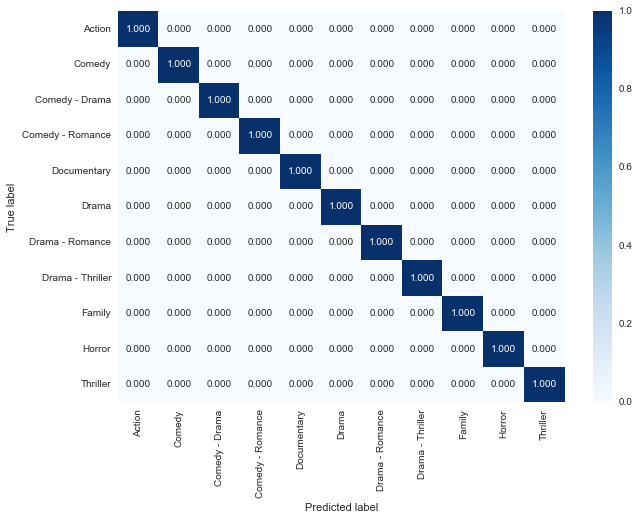

Test Accuracy: 0.4284
Test Precision - Weighted: 0.4244
Test Recall - Weighted: 0.4284
Test F1 - Weighted: 0.3945


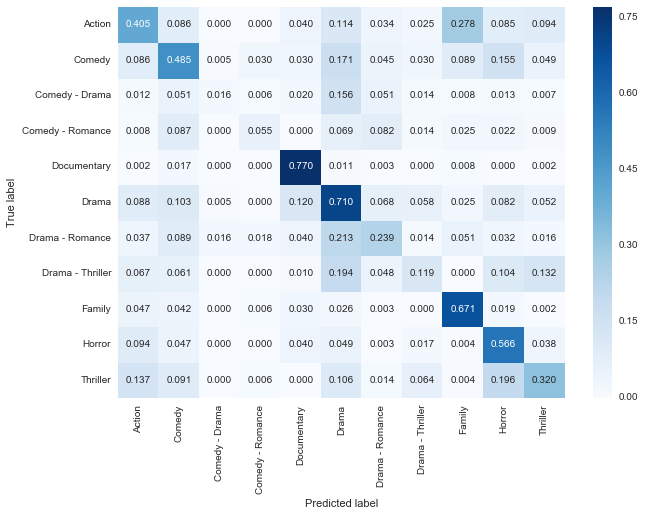

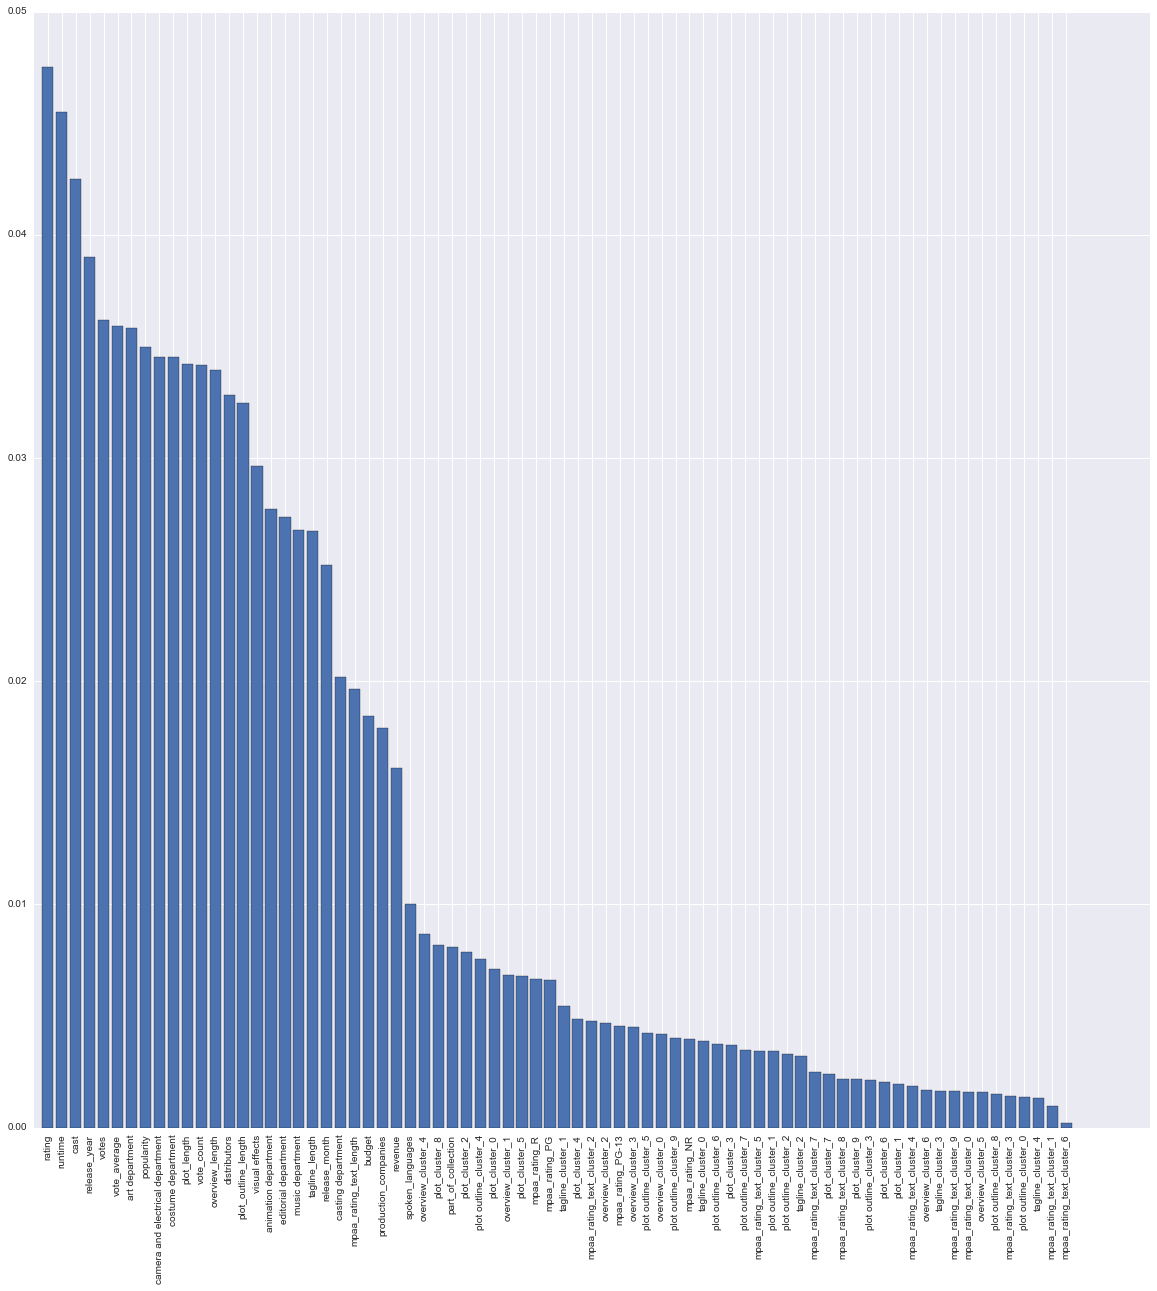

In [99]:
print(rf_model_cv.best_estimator_)
rf_model_chosen = rf_model_cv.best_estimator_
model_evaluation(X_train, y_train, rf_model_chosen, 'Train')
model_evaluation(X_test, y_test, rf_model_chosen, 'Test')
get_feature_importance(rf_model_chosen, X_train)

## Exclude Rating / Clustering

In [77]:
columns_to_include = [column for column in X_train.columns if 'cluster' not in column and 'mpaa_rating' not in column]
X_train_1 = X_train[columns_to_include]
X_test_1 = X_test[columns_to_include]

### Tune Model

In [78]:
rf_model = RandomForestClassifier()
rf_model_cv_1 = GridSearchCV(rf_model, RF_PARAMETERS, scoring = "f1", cv = 5)
rf_model_cv_1.fit(X_train_1, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'min_samples_leaf': [1, 10, 100], 'n_estimators': [500], 'random_state': [42], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [10, 100, None], 'class_weight': [None, 'balanced', 'balanced_subsample']},
       pre_dispatch='2*n_jobs', refit=True, scoring='f1', verbose=0)

### Evaluate Model

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=100, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)
Train Accuracy: 1.0000
Train Precision - Weighted: 1.0000
Train Recall - Weighted: 1.0000
Train F1 - Weighted: 1.0000


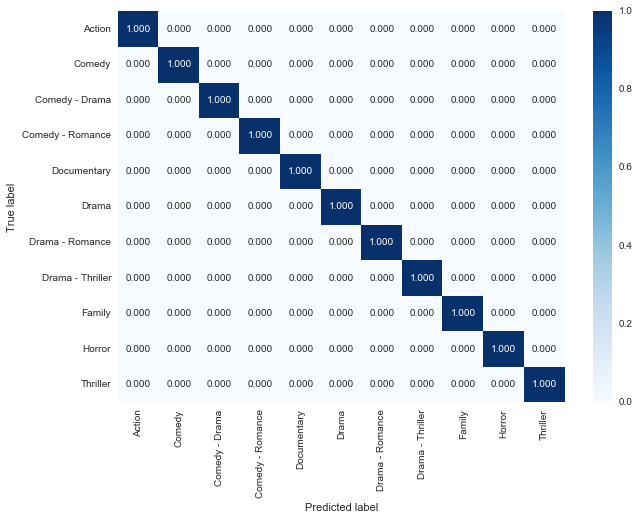

Test Accuracy: 0.3793
Test Precision - Weighted: 0.3627
Test Recall - Weighted: 0.3793
Test F1 - Weighted: 0.3366


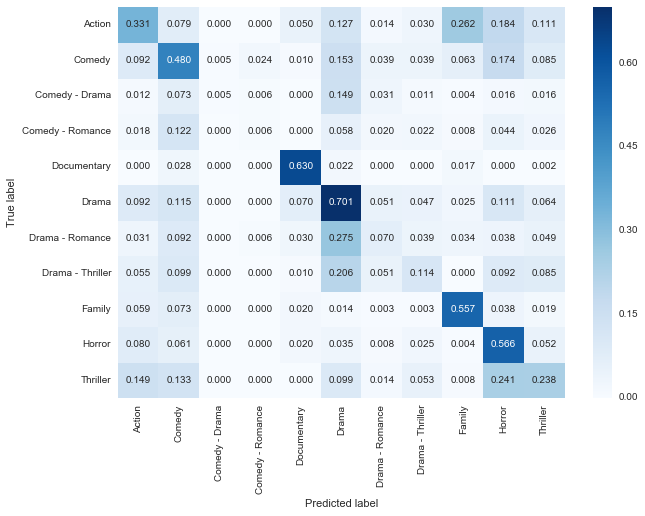

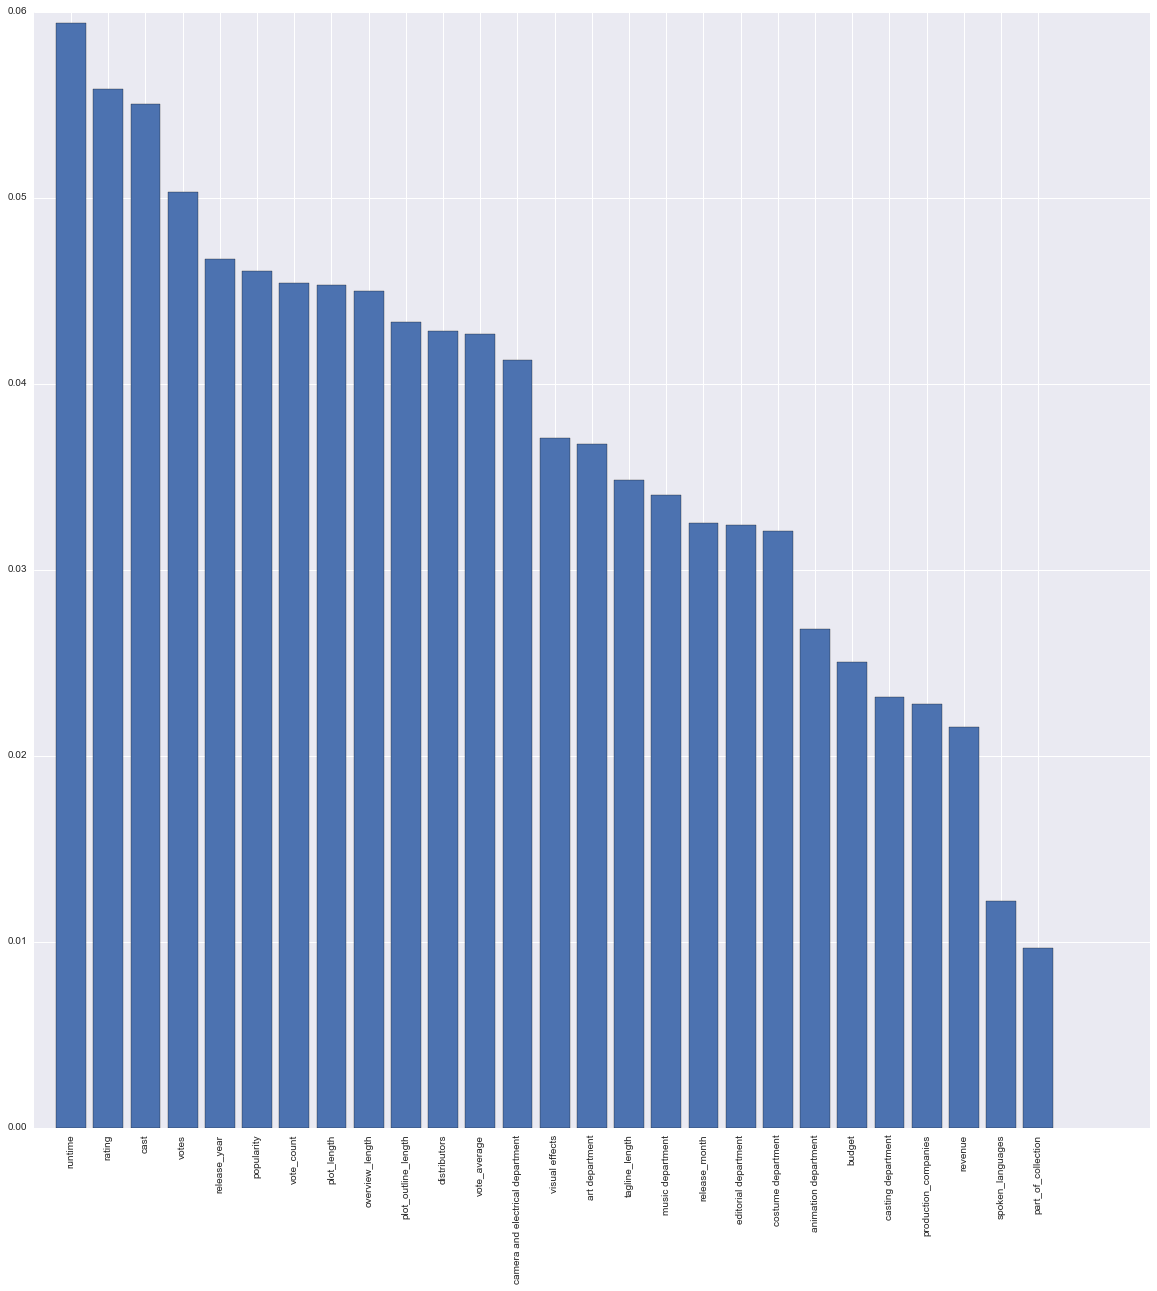

In [98]:
print(rf_model_cv_1.best_estimator_)
rf_model_chosen_1 = rf_model_cv_1.best_estimator_
model_evaluation(X_train_1, y_train, rf_model_chosen_1, 'Train')
model_evaluation(X_test_1, y_test, rf_model_chosen_1, 'Test')
get_feature_importance(rf_model_chosen_1, X_train_1)

## Top 10 Feature Importance

In [88]:
columns_to_include =['rating', 'runtime', 'cast', 'release_year', 'votes', 'vote_average', 'art department', 'popularity',
                'camera and electrical department', 'costume department']
X_train_2 = X_train[columns_to_include]
X_test_2 = X_test[columns_to_include]

### Tune

In [89]:
rf_model = RandomForestClassifier()
rf_model_cv_2 = GridSearchCV(rf_model, RF_PARAMETERS, scoring = "f1", cv = 5)
rf_model_cv_2.fit(X_train_2, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'min_samples_leaf': [1, 10, 100], 'n_estimators': [500], 'random_state': [42], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [10, 100, None], 'class_weight': [None, 'balanced', 'balanced_subsample']},
       pre_dispatch='2*n_jobs', refit=True, scoring='f1', verbose=0)

### Evaluate Model

RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='gini', max_depth=100, max_features='auto',
            max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)
Train Accuracy: 1.0000
Train Precision - Weighted: 1.0000
Train Recall - Weighted: 1.0000
Train F1 - Weighted: 1.0000


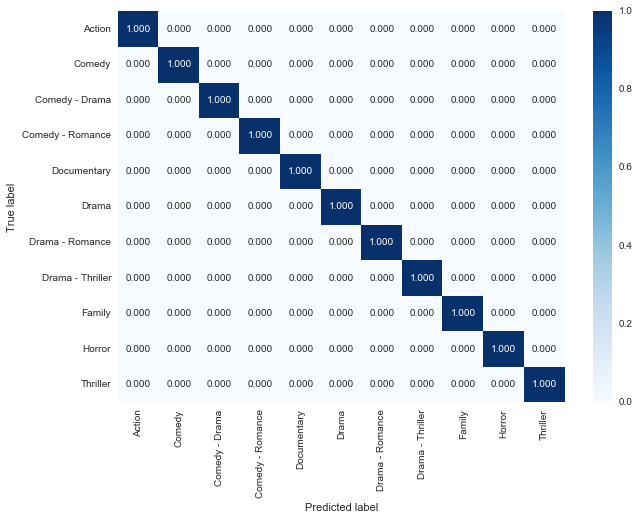

Test Accuracy: 0.3448
Test Precision - Weighted: 0.3106
Test Recall - Weighted: 0.3448
Test F1 - Weighted: 0.3123


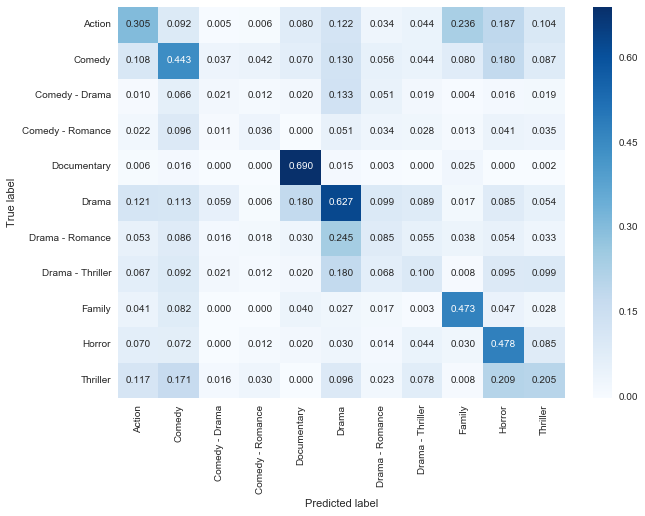

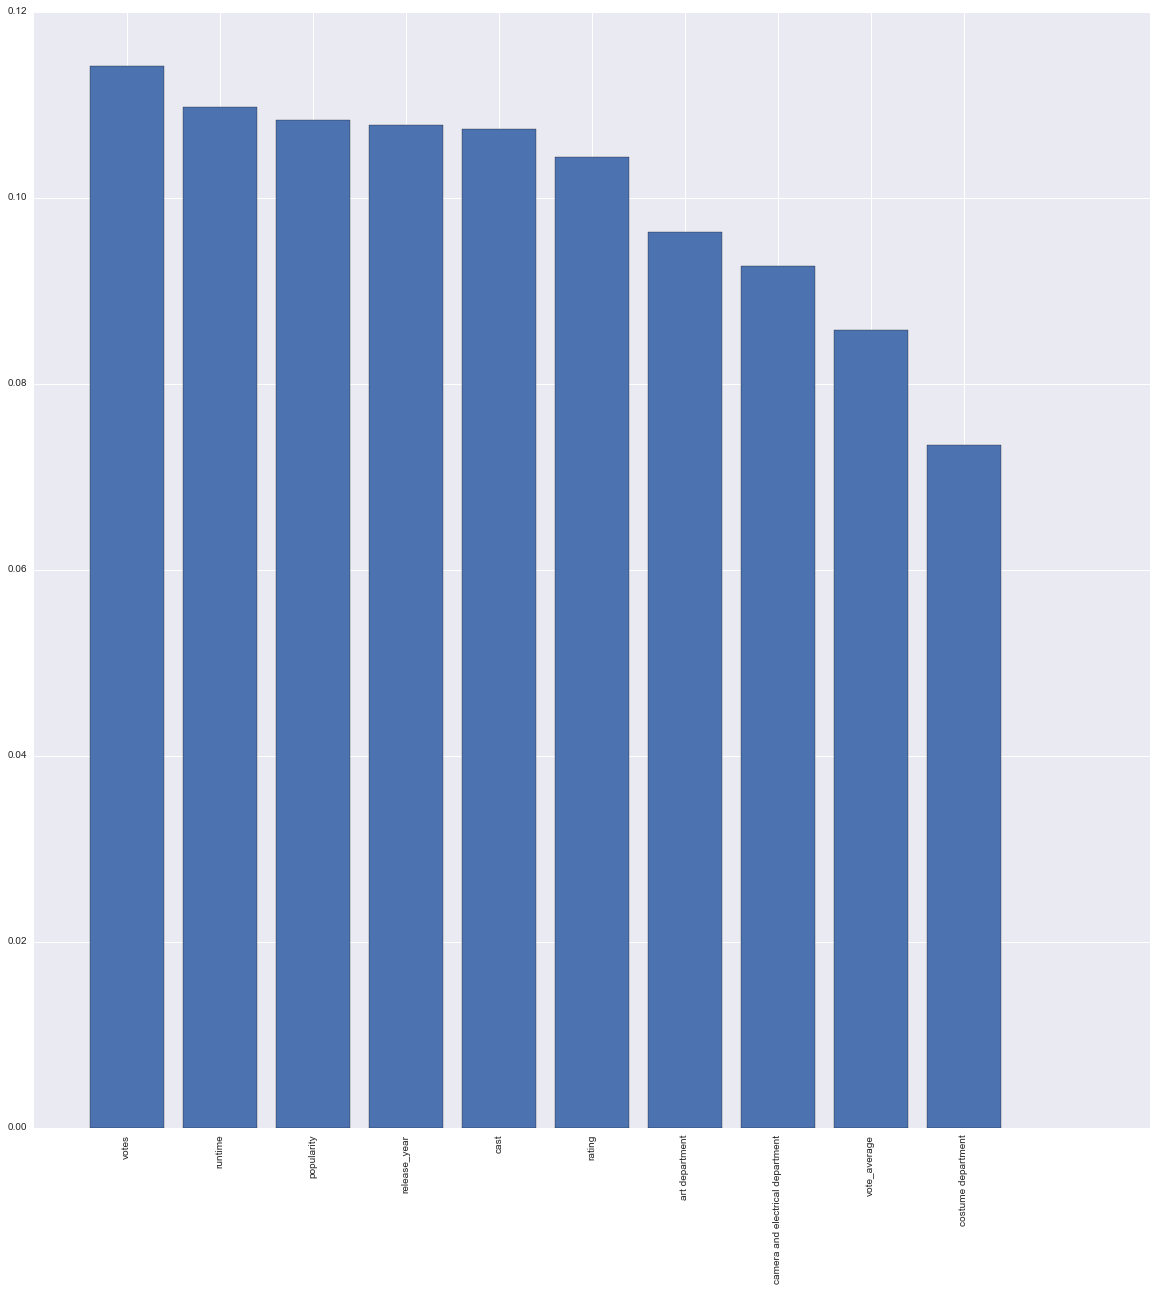

In [92]:
print(rf_model_cv_2.best_estimator_)
rf_model_chosen_2 = rf_model_cv_2.best_estimator_
model_evaluation(X_train_2, y_train, rf_model_chosen_2, 'Train')
model_evaluation(X_test_2, y_test, rf_model_chosen_2, 'Test')
get_feature_importance(rf_model_chosen_2, X_train_2)

# XGBoost

### Default Param Model

In [ ]:
xgb_model_1 = XGBClassifier()
xgb_model_1.fit(X_train, y_train)
model_evaluation(X_train, y_train, xgb_model_1, 'Train')

### First Tune max_depth and min_child_weight

In [ ]:
# parameter definitions
'''
max_depth : int
Maximum tree depth for base learners.
learning_rate : float
Boosting learning rate (xgb’s “eta”)
n_estimators : int
Number of boosted trees to fit.
silent : boolean
Whether to print messages while running boosting.
objective : string or callable
Specify the learning task and the corresponding learning objective or a custom objective function to be used (see note below).
nthread : int
Number of parallel threads used to run xgboost.
gamma : float
Minimum loss reduction required to make a further partition on a leaf node of the tree.
min_child_weight : int
Minimum sum of instance weight(hessian) needed in a child.
max_delta_step : int
Maximum delta step we allow each tree’s weight estimation to be.
subsample : float
Subsample ratio of the training instance.
colsample_bytree : float
Subsample ratio of columns when constructing each tree.
colsample_bylevel : float
Subsample ratio of columns for each split, in each level.
reg_alpha : float (xgb’s alpha)
L1 regularization term on weights
reg_lambda : float (xgb’s lambda)
L2 regularization term on weights
scale_pos_weight : float
Balancing of positive and negative weights.
base_score:
The initial prediction score of all instances, global bias.
seed : int
Random number seed.
'''
xgb_model_2 = XGBClassifier()
XGB_PARAMETERS = {'max_depth': range(3,10,2), 'min_child_weight': range(0,6,2)}
xgb_model_2_cv = GridSearchCV(xgb_model_2, XGB_PARAMETERS, scoring = "f1_weighted", cv = 5)
xgb_model_2_cv.fit(X_train, y_train)

In [ ]:
xgb_model_2_cv.grid_scores_, xgb_model_2_cv.best_params_, xgb_model_2_cv.best_score_

### Second: Tune gamma

In [ ]:
xgb_model_3 = XGBClassifier()
XGB_PARAMETERS = {k:[v] for k,v in xgb_model_2_cv.best_params_.items()}.copy()
XGB_PARAMETERS.update({'gamma': [i/10.0 for i in range(0,5)]})
print XGB_PARAMETERS
xgb_model_3_cv = GridSearchCV(xgb_model_3, XGB_PARAMETERS, scoring = "f1_weighted", cv = 5)
xgb_model_3_cv.fit(X_train, y_train)
xgb_model_3_cv.grid_scores_, xgb_model_3_cv.best_params_, xgb_model_3_cv.best_score_

### Third: Tune subsample and colsample_bytree

In [ ]:
xgb_model_4 = XGBClassifier()
XGB_PARAMETERS = {k:[v] for k,v in xgb_model_3_cv.best_params_.items()}.copy()
XGB_PARAMETERS.update({'subsample':[i/10.0 for i in range(6,10)],
                       'colsample_bytree':[i/10.0 for i in range(6,10)]})
xgb_model_4_cv = GridSearchCV(xgb_model_4, XGB_PARAMETERS, scoring = "f1_weighted", cv = 5)
xgb_model_4_cv.fit(X_train, y_train)
xgb_model_4_cv.grid_scores_, xgb_model_4_cv.best_params_, xgb_model_4_cv.best_score_

### Fourth: Tune regularization params

In [ ]:
xgb_model_5 = XGBClassifier()
XGB_PARAMETERS = {k:[v] for k,v in xgb_model_4_cv.best_params_.items()}.copy()
XGB_PARAMETERS.update({'reg_alpha':[1e-5, 1e-3, 0.1, 1, 10, 100]})
xgb_model_5_cv = GridSearchCV(xgb_model_5, XGB_PARAMETERS, scoring = "f1_weighted", cv = 5)
xgb_model_5_cv.fit(X_train, y_train)
xgb_model_5_cv.grid_scores_, xgb_model_5_cv.best_params_, xgb_model_5_cv.best_score_

In [ ]:
xgb_model_6 = XGBClassifier()
XGB_PARAMETERS = {k:[v] for k,v in xgb_model_5_cv.best_params_.items()}.copy()
XGB_PARAMETERS.update({'reg_alpha':[.01, .05, 0.1, .3, .5, .75]})
xgb_model_6_cv = GridSearchCV(xgb_model_6, XGB_PARAMETERS, scoring = "f1_weighted", cv = 5, verbose = 100)
xgb_model_6_cv.fit(X_train, y_train)
xgb_model_6_cv.grid_scores_, xgb_model_6_cv.best_params_, xgb_model_6_cv.best_score_

### Fifth: Reduce Learning Rate, Add More Tree

In [ ]:
xgb_model_final = XGBClassifier(
    learning_rate = 0.1,
    n_estimators = 1000,
    colsample_bytree = 0.9,
    gamma = 0.2,
    max_depth = 5,
    min_child_weight = 0,
    reg_alpha =0.1,
    subsample = 0.6)
print "here"
xgb_model_final.fit(X_train, y_train, verbose = 100)

In [ ]:
model_evaluation(X_train, y_train, xgb_model_final, 'Train')
model_evaluation(X_test, y_test, xgb_model_final, 'Test')
get_feature_importance(xgb_model_final, X_train)

# Compare Models

### RF Models

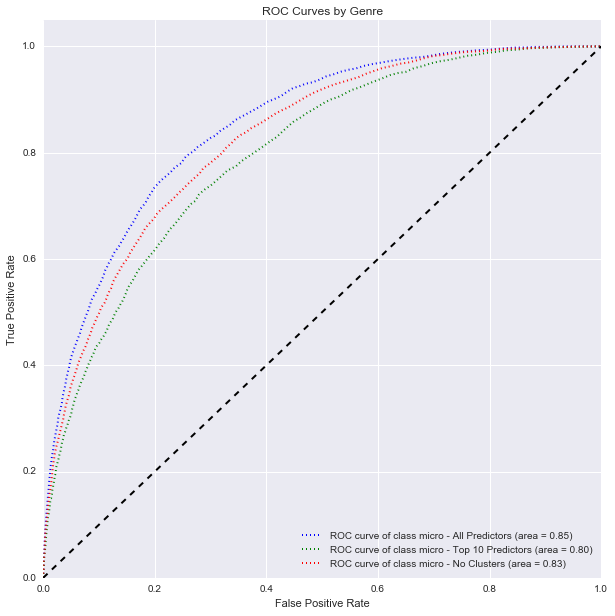

In [97]:
model_list_1 = [(rf_model_chosen, X_test), (rf_model_chosen_1, X_test_1), (rf_model_chosen_2, X_test_2)]
plot_roc(model_list_1, ['RF_All Predictors', 'RF_No Clusters', 'RF_Top 10 Predictors'], y_test)

### RF and XGB Model Comparison

In [ ]:
model_list_2 = [(rf_model_chosen, X_test), (xgb_model_final, X_test)]
plot_roc(model_list_2, ['Random Forest', 'XGBoost'], y_test)